In [1]:
import torch
import scipy
from torchmetrics.retrieval import RetrievalNormalizedDCG, RetrievalMAP
from src.dataset import TestDataset, OnlineCoverSongDataset
from src.evaluation import RetrievalEvaluation
from src.baselines.blocking import Blocker
from rapidfuzz import fuzz

mAP = RetrievalMAP(empty_target_action="skip")

fuzzy_valset = TestDataset(
        "shs100k2_val",
        "/data/csi_datasets/",
        "/data/yt_metadata.parquet",
        tokenizer="roberta-base"
        )


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fuzzy_valset = TestDataset(
        "shs100k2_test",
        "/data/csi_datasets/",
        "/data/yt_metadata.parquet",
        tokenizer="roberta-base"
        )



In [10]:
torch.sum(fuzzy_valset.get_target_matrix(), dim=1)


tensor(5)

# Fuzzy Matching

In [3]:
# get audio preds
audio_preds = fuzzy_valset.get_csi_pred_matrix("coverhunter").to("cuda")

# get text preds
blocker = Blocker(blocking_func=fuzz.token_ratio, threshold=0.5)
left_df, right_df = fuzzy_valset.get_dfs_by_task("svShort")
text_preds = blocker.predict(left_df, right_df).to("cuda")
text_preds = text_preds.fill_diagonal_(-float('inf')) / 100
text_preds

# get ground truth
Y = fuzzy_valset.get_target_matrix().to(float).to("cuda")

m, n = Y.shape
indexes = torch.arange(m).view(-1, 1).expand(-1, n).to("cuda")


## Grid Search

In [4]:
import numpy as np

def predict(x1,x2, w2):
    return ((1 - w2) * x1 + w2 * x2)

for i in np.arange(0.1, 1, 0.1):
    preds = predict(text_preds, audio_preds, i)
    map_result = mAP(preds, Y, indexes)
    print(f"MAP: {map_result} for audio weight of {i}")


MAP: 0.6257272958755493 for audio weight of 0.1
MAP: 0.6896862387657166 for audio weight of 0.2
MAP: 0.7650094628334045 for audio weight of 0.30000000000000004
MAP: 0.8439185619354248 for audio weight of 0.4
MAP: 0.9097827672958374 for audio weight of 0.5
MAP: 0.9489179849624634 for audio weight of 0.6
MAP: 0.9662358164787292 for audio weight of 0.7000000000000001
MAP: 0.968373715877533 for audio weight of 0.8
MAP: 0.9598760008811951 for audio weight of 0.9


### Linear Programming

In [5]:
from scipy.optimize import minimize, linprog

def mAP_combined(weights, text_preds, audio_preds, Y, index):
    combined_preds = weights[0] * text_preds + weights[1] * audio_preds
    result = mAP(torch.tensor(combined_preds).cpu(), Y.cpu(), index.cpu())
    print(f"Intermediate mAP: {result}, weights: {weights}")
    return -result

# Initial weights (sum of weights should be 1)
initial_weights = [0.2, 0.8]

# Optimization bounds for weights (between 0 and 1)
bnd = [(0, 1), (0, 1)]

# Optimization
preds_a = torch.where(text_preds == float('-inf'), 0, text_preds).cpu().numpy()
preds_b = torch.where(audio_preds == float('-inf'), 0, audio_preds).cpu().numpy()

result = minimize(mAP_combined, initial_weights, args=(preds_a, preds_b, Y, indexes), bounds=bnd, method="SLSQP")

# optimized data
optimized_weights = result.x
optimized_combined_preds = optimized_weights[0] * preds_a + optimized_weights[1] * preds_b
optimized_map = mAP(torch.tensor(optimized_combined_preds).cpu(), Y.cpu(), indexes.cpu())

print("Optimized Weights:", optimized_weights)
print("Optimized mAP:", optimized_map)


Intermediate mAP: 0.968373715877533, weights: [0.2 0.8]
Intermediate mAP: 0.968373715877533, weights: [0.20000001 0.8       ]
Intermediate mAP: 0.968373715877533, weights: [0.2        0.80000001]
Optimized Weights: [0.2 0.8]
Optimized mAP: tensor(0.9684)


### Method from Wu, "Adapting boosting for information retrieval measures"

In [6]:

def wu_method(text_preds, audio_preds, tolerance=0.001, shrinkage_factor=0.1):

    # Initial values for best parameters
    best_i = None
    best_map = -1

    # First loop
    for i in np.arange(0.1, 1, 0.1):
        preds = predict(text_preds, audio_preds, i)
        map_result = mAP(preds, Y, indexes)

        print(f"MAP: {map_result} for audio weight of {i}")

        # Update best parameters if needed
        if map_result > best_map:
            best_i = i
            best_map = map_result

    # Second loop (nested within the first loop)
    while True:
        # Determine the search range based on shrinkage
        search_range = np.arange(max(0.1, best_i - shrinkage_factor), min(1, best_i + shrinkage_factor), shrinkage_factor * 0.1)

        found_better = False

        for i in search_range:
            preds = predict(text_preds, audio_preds, i)
            map_result = mAP(preds, Y, indexes)

            print(f"MAP: {map_result} for audio weight of {i}")

            # Update best parameters if needed
            if map_result > best_map:
                best_i = i
                best_map = map_result
                found_better = True

        # Check the stopping condition based on tolerance
        if not found_better or (max(search_range) - min(search_range)) < tolerance:
            break
    
    print("Best audio weight:", best_i)
    print("Best MAP:", best_map)
    return best_i, best_map

    
# cqtnet
audiomodel = "cqtnet"
audio_preds = fuzzy_valset.get_csi_pred_matrix(audiomodel)
aw, bmap = wu_method(text_preds, audio_preds, tolerance=0.001, shrinkage_factor=0.1)
print(f"{audiomodel}: audio weight {aw} -- MAP: {bmap}")


MAP: 0.36789849400520325 for audio weight of 0.1
MAP: 0.4136251211166382 for audio weight of 0.2
MAP: 0.4498225152492523 for audio weight of 0.30000000000000004
MAP: 0.46873387694358826 for audio weight of 0.4
MAP: 0.4721739590167999 for audio weight of 0.5
MAP: 0.46430814266204834 for audio weight of 0.6
MAP: 0.4479917883872986 for audio weight of 0.7000000000000001
MAP: 0.42718708515167236 for audio weight of 0.8
MAP: 0.4039953052997589 for audio weight of 0.9
MAP: 0.46873387694358826 for audio weight of 0.4
MAP: 0.46978142857551575 for audio weight of 0.41000000000000003
MAP: 0.47065120935440063 for audio weight of 0.42000000000000004
MAP: 0.47128501534461975 for audio weight of 0.43000000000000005
MAP: 0.47176072001457214 for audio weight of 0.44000000000000006
MAP: 0.47213488817214966 for audio weight of 0.45000000000000007
MAP: 0.472449392080307 for audio weight of 0.4600000000000001
MAP: 0.47255733609199524 for audio weight of 0.4700000000000001
MAP: 0.4725513160228729 for audio

### XGBoost with MAP as Objective Function

In [15]:
import numpy as np

y_train = Y.cpu().numpy().flatten()
X_train = np.concatenate([preds_a.reshape(-1, 1), preds_b.reshape(-1, 1)], axis=1)

# get query info array
length_sqrt = int(np.sqrt(len(y_train)))
group_array = np.full(length_sqrt, np.sqrt(len(y_train)))
qids = indexes.cpu().numpy().flatten()


In [16]:
import xgboost as xgb

model = xgb.XGBRanker(objective="rank:map")
model.fit(X_train, y_train, qid=qids)



XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
model2 = xgb.XGBRanker(objective="rank:map")
model2.fit(X_train, y_train, qid=qids)


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

In [33]:
preds_ltr = model2.predict(X_train)
n = len(preds_ltr)
matrix_size = int(np.sqrt(n))

# Reshape the flattened array to the unflattened square matrix
preds_ltr = preds_ltr.reshape((matrix_size, matrix_size))

preds_norm = (preds_ltr - np.min(preds_ltr)) / (np.max(preds_ltr) - np.min(preds_ltr))

map_result = mAP(torch.tensor(preds_norm), Y.cpu(), indexes.cpu())
print(f"MAP: {map_result}")



MAP: 0.8988904356956482


### LambdaMART


In [114]:
import lightgbm as lgb

lambdamart_params = {
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'map',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

ranker = lgb.LGBMRanker(**lambdamart_params)
                    #label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=group_array,
      eval_set=[(X_train, y_train)],
      eval_group=[group_array],
      eval_at=[4, 8])



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRanker(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
           learning_rate=0.05, metric='ndcg', objective='lambdarank',
           verbose=0)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

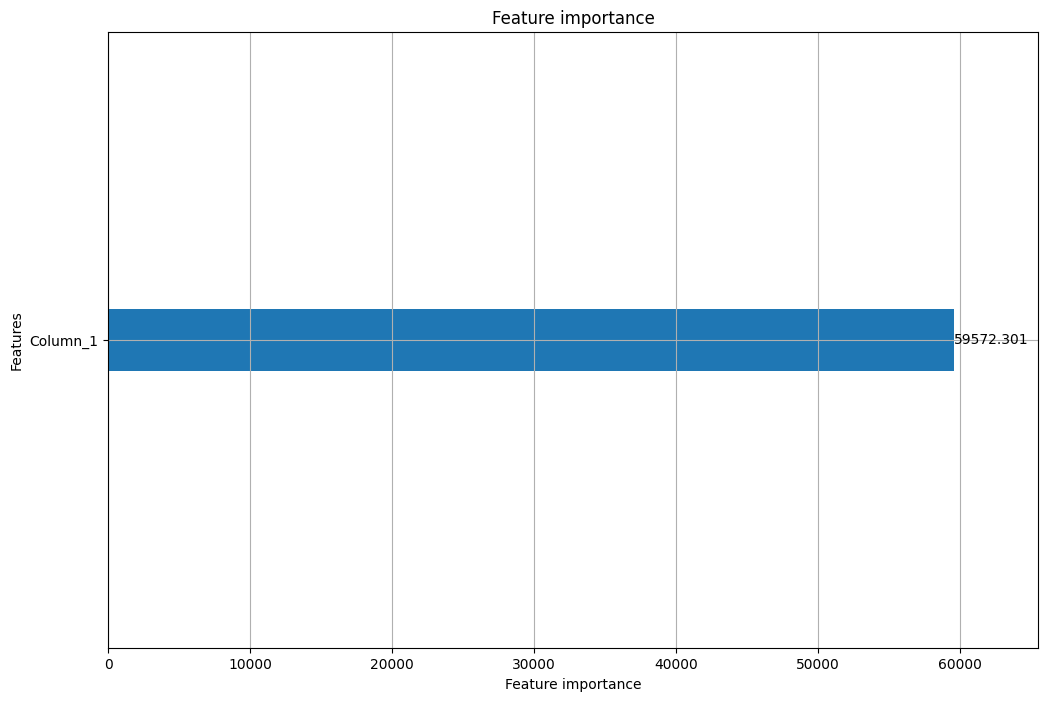

In [108]:
lgbm.plot_importance(ranker, figsize = (12,8))


In [88]:
result_array

array([8819., 8819., 8819., ..., 8819., 8819., 8819.])

In [29]:
np.nan_to_num(float('-inf')) 

True

# S-BERT

In [38]:
dataset_name = "shs100k2_val"
sbert_valset = OnlineCoverSongDataset(
        dataset_name,
        "/data/csi_datasets/",
        "/data/yt_metadata.parquet",
        "tvShort"
)  


# get audio preds
audio_preds = sbert_valset.get_csi_pred_matrix("coverhunter").to("cuda")


# get text preds
text_preds = torch.load(f"preds/sentence-transformers/{dataset_name}/preds.pt")
text_preds = text_preds.fill_diagonal_(0)
text_preds

# get ground truth
Y = sbert_valset.get_target_matrix().to(float).to("cuda")

m, n = Y.shape
indexes = torch.arange(m).view(-1, 1).expand(-1, n).to("cuda")



In [39]:
for i in np.arange(0.1, 1, 0.1):
    preds = predict(text_preds, audio_preds, i)
    map_result = mAP(preds, Y, indexes)
    print(f"MAP: {map_result} for audio weight of {i}")



MAP: 0.824760913848877 for audio weight of 0.1
MAP: 0.8403883576393127 for audio weight of 0.2
MAP: 0.8586575984954834 for audio weight of 0.30000000000000004
MAP: 0.8782891035079956 for audio weight of 0.4
MAP: 0.9014644026756287 for audio weight of 0.5
MAP: 0.9287620186805725 for audio weight of 0.6
MAP: 0.9586793780326843 for audio weight of 0.7000000000000001
MAP: 0.9774288535118103 for audio weight of 0.8
MAP: 0.9749596118927002 for audio weight of 0.9
